In [1]:
%matplotlib inline
import d2l
import mxnet as mx
from mxnet import autograd, gluon, init, nd
from mxnet.gluon import data as gdata, loss as gloss, nn, utils
import numpy as np
import matplotlib.pyplot as plt

mnist_train = gdata.vision.FashionMNIST(train=True)
mnist_test = gdata.vision.FashionMNIST(train=False)

/Users/Derek/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


1.1

In [2]:
def loss(o, y):
    loss = gluon.loss.LogisticLoss()
    return loss(o, y)

1.2

In [3]:
def grad(forward_func, o):
    o.attach_grad()
    with autograd.record():
        z = forward_func(o, nd.array([1]))
    z.backward()
    return o.grad

In [4]:
zeros = nd.arange(-5, 5, step=0.11)
oneDerivs = nd.zeros(zeros.shape)
for i in range(len(zeros)):
    oneDerivs[i] = grad(loss, zeros[i]).asscalar()

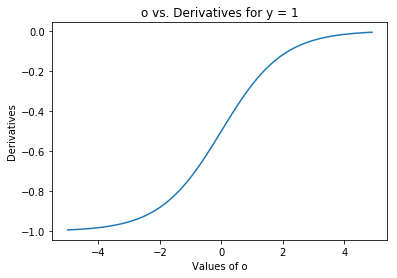

In [5]:
plt.plot(zeros.asnumpy(), oneDerivs.asnumpy())
plt.xlabel('Values of o')
plt.ylabel('Derivatives')
plt.title('o vs. Derivatives for y = 1')
plt.show()

1.3

In [7]:
shirt_sweater = []
sandal_sneaker = []
#shirt: 6, sweater: 2, sandal: 5, sneaker: 7
for i in range(len(mnist_train._label)):
    label = mnist_train._label[i]
    if label == 6 or label == 2:
        shirt_sweater.append(i)
    elif label == 5 or label == 7:
        sandal_sneaker.append(i)

class_1_train = mnist_train[shirt_sweater][0]
class_neg1_train = mnist_train[sandal_sneaker][0]

class_1_train = class_1_train.reshape(12000, 784)
class_neg1_train = class_neg1_train.reshape(12000, 784)


In [8]:
class_1_test_data = []
class_neg1_test_data = []
#shirt: 6, sweater: 2, sandal: 5, sneaker: 7
for i in range(len(mnist_test._label)):
    label = mnist_test._label[i]
    if label == 6 or label == 2:
        class_1_test_data.append(i)
    elif label == 5 or label == 7:
        class_neg1_test_data.append(i)


In [9]:
class_1_test = mnist_test[class_1_test_data][0]
class_neg1_test = mnist_test[class_neg1_test_data][0]

class_1_test = class_1_test.reshape(2000, 784)
class_neg1_test = class_neg1_test.reshape(2000, 784)
class_1_test


[[ 0  0  0 ...  0  0  0]
 [ 0  0  0 ... 56  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ... 34  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]
<NDArray 2000x784 @cpu(0)>

1.4

In [30]:
train_data = nd.concat(class_1_train, class_neg1_train, dim = 0)
train_data = train_data.astype('float32')
train_labels = nd.concat(nd.ones(len(class_1_train)), nd.ones(len(class_neg1_train))*-1, dim = 0)
train_labels = train_labels.astype('float32')
print(train_data.shape, train_labels.shape)

(24000, 784) (24000,)


In [34]:
test_data = nd.concat(class_1_test, class_neg1_test, dim = 0)
test_data = test_data.astype('float32')
test_labels = nd.concat(nd.ones(len(class_1_test_data)), nd.ones(len(class_neg1_test_data))*-1, dim = 0)
print(test_data.shape, test_labels.shape)

def makeTrainData(class1, class0, size, l):
    class1 = class1[:l*size]
    class0 = class0[:(1-l)*size]
    train_data = nd.concat(class1, class0, dim = 0)
    train_data = train_data.astype('float32')
    train_labels = nd.concat(nd.ones(len(class1)), nd.ones(len(class0))*-1, dim = 0)
    train_labels = train_labels.astype('float32')
    return (train_data, train_labels)



(4000, 784) (4000,)


In [60]:
def makeTrainData(class1, class0, size, l):
    class1 = class1[:int(l*size)]
    class0 = class0[:int((1-l)*size)]

    train_data = nd.concat(class1, class0, dim = 0)
    train_data = train_data.astype('float32')
    train_labels = nd.concat(nd.ones(len(class1)), nd.ones(len(class0))*-1, dim = 0)
    train_labels = train_labels.astype('float32')
    return (train_data, train_labels)

train_data, train_labels = makeTrainData(class_1_train, class_neg1_train, 12000, .5)


In [80]:
def logistic(z):
    return 1. / (1. + nd.exp(-z))

def train_and_predict(Xtrain, ytrain, Xtest, ytest):
    batch_size = 64
    num_epochs = 20
    
    train_dataset = gdata.ArrayDataset(Xtrain, ytrain)
    train_iter = gdata.DataLoader(train_dataset, batch_size, shuffle=True)

    def loss(o, y):
        loss = gluon.loss.LogisticLoss()
        return loss(o, y)

    def net():
        net = nn.Sequential()
        net.add(nn.Dense(1))
        net.initialize(init.Normal(sigma=1))
        return net

    net = net()
    trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.1})
    for epoch in range(num_epochs):
        for X, y in train_iter:
            with autograd.record():
                l = loss(net(X), y)
            l.backward()
            trainer.step(batch_size)
        l = loss(net(Xtrain), ytrain)
        #print('epoch %d, loss: %f' % (epoch, l.mean().asnumpy()))
    
    pred_labels = net(Xtest)
    predictions = []
    for i in pred_labels:
        if i.asscalar() > 0:
            predictions.append(1)
        else:
            predictions.append(-1)
    predictions = np.asarray(predictions)
    actual = ytest.astype("int").asnumpy()

    return np.count_nonzero(predictions == actual)/len(predictions)

In [65]:
# full test set
train_data, train_labels = makeTrainData(class_1_train, class_neg1_train, 24000, .5)

train_and_predict(train_data, train_labels, test_data, test_labels)

0.9995

In [66]:
# half test set
train_data, train_labels = makeTrainData(class_1_train, class_neg1_train, 12000, .5)

train_and_predict(train_data, train_labels, test_data, test_labels)

0.99875

2.1

In [67]:
lambdas = [.05, .1, .2, .3, .4, .5, .6, .7, .8, .9, .95]

datasets = list(map(lambda x: makeTrainData(class_1_train, class_neg1_train, 12000, x), lambdas))

2.2

In [68]:
i = 0
for train_data, train_labels in datasets:
    print(str(lambdas[i]) + " accuracy: " + str(train_and_predict(train_data, train_labels, test_data, test_labels)))
    i = i + 1

0.05 accuracy: 0.99575
0.1 accuracy: 0.99875
0.2 accuracy: 0.999
0.3 accuracy: 0.99875
0.4 accuracy: 0.99875
0.5 accuracy: 0.999
0.6 accuracy: 0.999
0.7 accuracy: 0.99875
0.8 accuracy: 0.99825
0.9 accuracy: 0.996
0.95 accuracy: 0.9935


3.1. We want to reweight all of our training data by exp(min(f(xi), c))

3.2.

In [97]:
# unbiased
ub_train_data, ub_train_labels = makeTrainData(class_1_train, class_neg1_train, 12000, .5)

#biased
biased_train_data, biased_train_labels = makeTrainData(class_1_train, class_neg1_train, 12000, .1)

#for binary classifier on test vs train
train_data = nd.concat(ub_train_data, test_data, dim = 0)
ub1_train_data = train_data.astype('float32')
train_labels = nd.concat(nd.ones(len(ub_train_data)), nd.ones(len(test_data))*-1, dim = 0)
ub1_train_labels = train_labels.astype('float32')
                         
train_data = nd.concat(biased_train_data, test_data, dim = 0)
b1_train_data = train_data.astype('float32')
train_labels = nd.concat(nd.ones(len(biased_train_data)), nd.ones(len(test_data))*-1, dim = 0)
b1_train_labels = train_labels.astype('float32')

def train_for_weights(Xtrain, ytrain):
    batch_size = 16
    num_epochs = 20
    
    print(ytrain)
    train_dataset = gdata.ArrayDataset(Xtrain, ytrain)
    train_iter = gdata.DataLoader(train_dataset, batch_size, shuffle=True)

    def loss(o, y):
        loss = gluon.loss.LogisticLoss()
        return loss(o, y)

    def net():
        net = nn.Sequential()
        net.add(nn.Dense(1))
        net.initialize(init.Normal(sigma=1))
        return net

    net = net()
    trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.01})
    for epoch in range(num_epochs):
        for X, y in train_iter:
            with autograd.record():
                l = loss(net(X), y)
            l.backward()
            trainer.step(batch_size)
        l = loss(net(Xtrain), ytrain)
        print('epoch %d, loss: %f' % (epoch, l.mean().asnumpy()))
    
    return net(Xtrain)
                         
train_for_weights(ub1_train_data, ub1_train_labels)


[ 1.  1.  1. ... -1. -1. -1.]
<NDArray 16000 @cpu(0)>
epoch 0, loss: 3963.504395
epoch 1, loss: 3580.795898
epoch 2, loss: 913.939026
epoch 3, loss: 1298.052734
epoch 4, loss: 5932.034180
epoch 5, loss: 1004.988037
epoch 6, loss: 6137.037109
epoch 7, loss: 2826.469971
epoch 8, loss: 10062.743164
epoch 9, loss: 6568.000000
epoch 10, loss: 1387.622192
epoch 11, loss: 4624.299805
epoch 12, loss: 3747.817871
epoch 13, loss: 3906.764648
epoch 14, loss: 6302.432617
epoch 15, loss: 3515.139404
epoch 16, loss: 8976.093750
epoch 17, loss: 3615.606201
epoch 18, loss: 999.907471
epoch 19, loss: 1323.540894



[[ 2700.04   ]
 [  893.33295]
 [-2629.5718 ]
 ...
 [ 2640.728  ]
 [ 1266.9835 ]
 [ 2122.7158 ]]
<NDArray 16000x1 @cpu(0)>

In [98]:
train_for_weights(b1_train_data,b1_train_labels)


[ 1.  1.  1. ... -1. -1. -1.]
<NDArray 16000 @cpu(0)>
epoch 0, loss: 3744.067871
epoch 1, loss: 3223.222900
epoch 2, loss: 1034.274170
epoch 3, loss: 2775.221191
epoch 4, loss: 2080.456055
epoch 5, loss: 1108.661987
epoch 6, loss: 2918.534668
epoch 7, loss: 3443.694580
epoch 8, loss: 2521.323730
epoch 9, loss: 1301.726440
epoch 10, loss: 1714.048584
epoch 11, loss: 1421.738770
epoch 12, loss: 1201.814209
epoch 13, loss: 4083.874268
epoch 14, loss: 754.815308
epoch 15, loss: 1624.795044
epoch 16, loss: 2816.681885
epoch 17, loss: 2397.985107
epoch 18, loss: 1037.171265
epoch 19, loss: 1069.557983



[[-161.50974]
 [2786.992  ]
 [  14.17483]
 ...
 [5453.8535 ]
 [ 379.6688 ]
 [7792.6426 ]]
<NDArray 16000x1 @cpu(0)>

3.3. Was unable to obtain proper weights for either class - both the weights went to inf since the function was taking the exp of a large number and the binary classifier did not converge when training to differentiate between train and test sets. However, we would expect the weights to be different

3.4

In [75]:
#if part 3 had worked, we would weight each training step by exp(net(xi)) in the training loop, however 
#the weights from the above part are unreliable since the binary classifier did not work very well and we 
#are left with meaningless weights


def train_with_shift(Xtrain, ytrain, Xtest, ytest):
    batch_size = 64
    num_epochs = 20
    
    train_dataset = gdata.ArrayDataset(Xtrain, ytrain)
    train_iter = gdata.DataLoader(train_dataset, batch_size, shuffle=True)

    def loss(o, y):
        loss = gluon.loss.LogisticLoss()
        return loss(o, y)

    def net():
        net = nn.Sequential()
        net.add(nn.Dense(1))
        net.initialize(init.Normal(sigma=1))
        return net

    net = net()
    trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.1})
    for epoch in range(num_epochs):
        for X, y in train_iter:
            with autograd.record():
                l = nd.exp(min(net(X), 1)) * loss(net(X), y)
            l.backward()
            trainer.step(batch_size)
        l = loss(net(Xtrain), ytrain)
        print('epoch %d, loss: %f' % (epoch, l.mean().asnumpy()))
    
    return net(Xtest)
